In [6]:
import semantic_kernel as sk
from services import Service
import re
import sqlite3
import pandas as pd
import os

async def PromptToQueryResult(debug=False, prompt_rephrase=False):
    """
    Prompts the user for a query, rephrases the prompt if required, and executes the query using the Semantic Kernel.

    Args:
        debug (bool, optional): If True, prints debug information. Defaults to False.
        prompt_rephrase (bool, optional): If True, rephrases the prompt using a rephraser plugin. Defaults to False.

    Returns:
        DataFrame or any: The result of the executed query, or 'any' if no query is executed.
    """
    kernel = sk.Kernel()
    selectedService = Service.AzureOpenAI
    service_id = None
    if selectedService == Service.OpenAI:
        from semantic_kernel.connectors.ai.open_ai import OpenAIChatCompletion

        api_key, org_id = sk.openai_settings_from_dot_env()
        service_id = "gpt4-32k"
        kernel.add_service(
            OpenAIChatCompletion(service_id=service_id, ai_model_id="gpt4-32k", api_key=api_key, org_id=org_id),
        )
    elif selectedService == Service.AzureOpenAI:
        from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

        deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
        service_id = "aoai_chat_completion"
        kernel.add_service(
            AzureChatCompletion(service_id=service_id, deployment_name=deployment, endpoint=endpoint, api_key=api_key),
        )
    
    query = input("Enter your query: ")  # Get query from user
    rephrased_prompt = query
    
    plugins_directory = "plugins"
    file_path = "data_schema.txt"
    data_schema = read_data_schema_from_file(file_path)
    if(prompt_rephrase):
        promptFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "PromptPlugin")
        rephraserFunction = promptFunctions["PromptRephraser"]
        rephrased_prompt = await kernel.invoke(rephraserFunction, sk.KernelArguments(data_schema=data_schema, query=query))

    dataFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "DataPlugin")
    descriptorFunction = dataFunctions["DatabaseDescriptor"]

    
    result = await kernel.invoke(descriptorFunction, sk.KernelArguments(data_schema=data_schema, query= rephrased_prompt))
    result_string = result.data if hasattr(result, 'data') else str(result)
    if(debug):
        print(result_string)
    matches_sql = parse_text_between_tags(result_string,"<sql>", "</sql>")


    print(rephrased_prompt)
    if len(matches_sql) > 0:
        if debug:
            print(matches_sql[0])
        df = run_sql_query(matches_sql[0])
    
    

    matches_python = parse_text_between_tags(result_string,"<python>", "</python>")
    if len(matches_python) > 0:
        if debug:
            print(matches_python[0])
        try:
            db_conn = os.getenv("DB_CONNECTION_STRING")
            conn = sqlite3.connect(db_conn)
            exec(matches_python[0])
            conn.close()
        except Exception as e:
            if debug:
                print('hata:' + e)
        except:
            print("An exception occurred")
    if len(matches_sql) > 0:
        df.head()
        return df
    else:  
        return any


def read_data_schema_from_file(file_path):
    """
    Reads the data schema from a file.

    Args:
        file_path (str): The path to the file containing the data schema.

    Returns:
        str: The contents of the file as a string.

    Raises:
        FileNotFoundError: If the file does not exist.

    """
    with open(file_path, 'r') as file:
        data_schema = file.read()
    return data_schema

def parse_text_between_tags(text, start_tag, end_tag):
    """
    Parses the text between the specified start and end tags.

    Args:
        text (str): The text to search within.
        start_tag (str): The start tag to look for.
        end_tag (str): The end tag to look for.

    Returns:
        list: A list of matches found between the start and end tags.
    """
    pattern = rf"{re.escape(start_tag)}(.*?){re.escape(end_tag)}"
    matches = re.findall(pattern, text, re.DOTALL)
    return matches

def run_sql_query(query):
    """
    Executes the given SQL query and returns the result as a pandas DataFrame.

    Parameters:
    query (str): The SQL query to be executed.

    Returns:
    pandas.DataFrame: The result of the SQL query as a DataFrame.
    """
    db_conn = os.getenv("DB_CONNECTION_STRING")
    conn = sqlite3.connect(db_conn)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df



Error parsing XML of prompt: not well-formed (invalid token): line 339, column 98


<sql>
SELECT staffs.first_name, staffs.last_name, SUM(order_items.quantity) as total_sales
FROM staffs
JOIN orders ON staffs.staff_id = orders.staff_id
JOIN order_items ON orders.order_id = order_items.order_id
GROUP BY staffs.staff_id
</sql>

<python>
import matplotlib.pyplot as plt
import pandas as pd

# Assuming that 'df' is a pandas DataFrame containing the result of the above SQL query
# df = pd.read_sql_query(sql, conn)

# Sample data
staff_names = df['first_name'] + " " + df['last_name']
sales = df['total_sales']

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(sales, labels=staff_names, autopct='%1.1f%%', startangle=140)

# Add title
plt.title('Sales Performance of Each Staff Member')

# Show plot
plt.show()
</python>
Generate a pie chart to display the sales performance of each staff member.

SELECT staffs.first_name, staffs.last_name, SUM(order_items.quantity) as total_sales
FROM staffs
JOIN orders ON staffs.staff_id = orders.staff_id
JOIN order_items ON orders.order_id

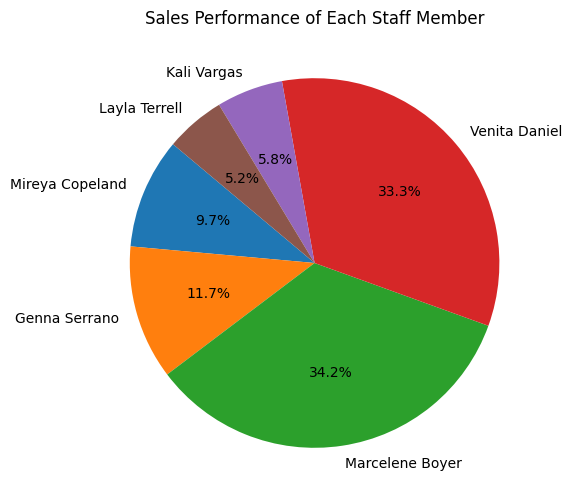

,first_name,last_name,total_sales
0,Mireya,Copeland,685
1,Genna,Serrano,831
2,Marcelene,Boyer,2419
3,Venita,Daniel,2360
4,Kali,Vargas,412
5,Layla,Terrell,371


In [7]:
await PromptToQueryResult(prompt_rephrase=True, debug=True)
